In [297]:
import numpy as np
import pandas as pd
import open3d as o3d

import open3d as o3d
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import Delaunay
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

In [298]:
# Function to create transects based on theta2 values
def create_transects(dataframe, target_theta2_values, theta_range=1):
    return [dataframe[(dataframe['theta'] >= t - theta_range) & (dataframe['theta'] <= t + theta_range)] for t in target_theta2_values]

# Function to transform lidar point cloud to system coordinates
def transform_lidar(pcd_file, transformation_matrix):
    # Load point cloud data
    pcd = o3d.io.read_point_cloud(pcd_file)
    xyz = np.asarray(pcd.points)

    # Convert to spherical coordinates
    rho = np.linalg.norm(xyz, axis=1)
    theta_degrees = np.degrees(np.arccos(xyz[:, 2] / rho))

    # Create DataFrame with point cloud data and theta values
    point_cloud_df = pd.DataFrame(xyz, columns=['x', 'y', 'z'])
    point_cloud_df['theta'] = theta_degrees

    # Define target theta2 values and generate transects
    target_theta2_values = [97.2, 92.5, 90.0, 87.6, 84.9, 82.7, 80.4, 77.9, 75.7, 73.0, 70.9, 68.0, 66.0, 63.4, 60.9, 55.7]
    transects = create_transects(point_cloud_df, target_theta2_values)

    # Check for unassigned points
    unassigned_points_count = len(point_cloud_df) - sum(len(transect) for transect in transects)
    if unassigned_points_count > 0:
        print(f"Unassigned points count: {unassigned_points_count}")

    # Select Transect 3 and remove lidar frame points
    transect_A = transects[2]
    transect_A = transect_A[~(
        ((transect_A['y'] >= -700) & (transect_A['y'] <= 200) & 
         (transect_A['x'] >= -1100) & (transect_A['x'] <= 4000)) |
        (transect_A['x'] < -2000)
    )]

    # Apply transformation matrix to go to RD coordinates
    homogeneous_coords = np.hstack((transect_A[['x', 'y', 'z']], np.ones((transect_A.shape[0], 1))))
    transformed_coords = homogeneous_coords.dot(transformation_matrix.T)

    # Store transformed coordinates in DataFrame df_RD
    df_RD = pd.DataFrame(transformed_coords[:, :3], columns=['x', 'y', 'z'])

    # Define offset for system coordinates
    offset = [71683.5843540416, 452356.054802959]
    angle_rad = np.radians(36)
    cos_angle, sin_angle = np.cos(angle_rad), np.sin(angle_rad)

    # Transform to system coordinates
    df = pd.DataFrame({
        'x': (df_RD['x'] - offset[0]) * cos_angle - (df_RD['y'] - offset[1]) * sin_angle,
        'y': (df_RD['x'] - offset[0]) * sin_angle + (df_RD['y'] - offset[1]) * cos_angle,
        'z': df_RD['z']
    })

    # # Remove points where x is higher than 805
    # df = df[df['x'] <= 805]
    
    # Remove points where z is higher than 3 and x is lower than 790
    df = df[~((df['z'] > 3) & (df['x'] < 790))]

    # Add point with x=809, y=290.4, z=4.95
    new_point = pd.DataFrame({'x': [810], 'y': [290.4], 'z': [5.0]})
    df = pd.concat([df, new_point], ignore_index=True)


    return df



In [299]:
### S1 Dike in dune ###
offset = [71683.5843540416, 452356.054802959]
angle_rad = np.radians(36)
cos_angle, sin_angle = np.cos(angle_rad), np.sin(angle_rad)

# dike section
teen = [72494.97, 452125.915, 1.01]
kruin = [72504.20, 452119.20, 4.70]

teen_ns = [0, 0, 0]
kruin_ns = [0, 0, 0]

teen_ns[0] = (teen[0] - offset[0]) * cos_angle - (teen[1] - offset[1]) * sin_angle
teen_ns[1] = (teen[0] - offset[0]) * sin_angle + (teen[1] - offset[1]) * cos_angle
teen_ns[2] = teen[2]

kruin_ns[0] = (kruin[0] - offset[0]) * cos_angle - (kruin[1] - offset[1]) * sin_angle
kruin_ns[1] = (kruin[0] - offset[0]) * sin_angle + (kruin[1] - offset[1]) * cos_angle
kruin_ns[2] = kruin[2]

print(teen_ns)
print(kruin_ns)

[791.6975587170695, 290.7335049401803, 1.01]
[803.1117635442716, 290.726213701636, 4.7]


In [300]:
# Transformation matrix storm 1\
# all gcp 
transformation_matrix1 = np.array([
    [-0.002199340612, 0.813549220562, -0.581491947174, 492.125885009766],
    [-0.003037251998, -0.581496119499, -0.813543498516, 127.405715942383],
    [-0.999992966652, -0.000023121676, 0.003749861848, 4.598251342773],
    [0.000000000000, 0.000000000000, 0.000000000000, 1.000000000000]
])

# minus gcp 1
# transformation_matrix1 = np.array([
#     [0.001410950790, 0.812377512455, -0.583130180836, 492.112091064453],
#     [0.000446705671, -0.583131194115, -0.812377870083, 127.382499694824],
#     [-0.999998927116, 0.000885737652, -0.001185663044, 4.607468605042],
#     [0.000000000000, 0.000000000000, 0.000000000000, 1.000000000000]
# ])
transformation_matrix1[0:3, 0:3] *= 0.001
transformation_matrix1[0,3]+=  72000.00 
transformation_matrix1[1,3]+=  452000.00
# print(transformation_matrix1)

# Transformation matrix storm 2

transformation_matrix2 = np.array([
    [-0.020505372435, 0.811702489853, -0.583711028099, 492.117889404297],
    [0.007382744923, -0.583694934845, -0.811939477921, 127.374443054199],
    [-0.999762475491, -0.020958511159, 0.005976289976, 4.593192100525],
    [0.000000000000, 0.000000000000, 0.000000000000, 1.000000000000]
])

transformation_matrix2[0:3, 0:3] *= 0.001
transformation_matrix2[0,3]+=  72000.00 
transformation_matrix2[1,3]+=  452000.00
# print(transformation_matrix2)

# Transformation matrix storm 3

transformation_matrix3= np.array([
    [-0.004158232361, 0.815255224705, -0.579086899757, 492.086791992188],
    [0.001722776797, -0.579085230827, -0.815265178680, 127.338287353516],
    [-0.999989867210, -0.004387699533, 0.001003468060, 4.552772045135],
    [0.000000000000, 0.000000000000, 0.000000000000, 1.000000000000]
])
transformation_matrix3[0:3, 0:3] *= 0.001
transformation_matrix3[0,3]+=  72000.00 
transformation_matrix3[1,3]+=  452000.00
# print(transformation_matrix2)

# Transformation matrix storm 4
# Transformation matrix storm 5


In [301]:
# storm 1
pcd_file1_1 = r"U:\2024-12-18 to 2024-12-20, Storm 1\Lidars\20241220_LiDAR1\10s interval data\Lidar1__Pcl_0019_12_2024__00_00_00.206.PCD"
pcd_file1_2 = r"U:\2024-12-18 to 2024-12-20, Storm 1\Lidars\20241220_LiDAR1\10s interval data\Lidar1__Pcl_0019_12_2024__13_00_00.209.PCD"
pcd_file1_3 = r"U:\2024-12-18 to 2024-12-20, Storm 1\Lidars\20241220_LiDAR1\10s interval data\Lidar1__Pcl_0020_12_2024__01_00_00.206.PCD"

df1_1 = transform_lidar(pcd_file1_1, transformation_matrix1)
df1_2 = transform_lidar(pcd_file1_2, transformation_matrix1)
df1_3 = transform_lidar(pcd_file1_3, transformation_matrix1)

In [302]:
# Storm 2 
pcd_file2_1 = r"U:\2024-12-22, Storm 2\Lidars\20241223_LiDAR1\10s interval data\Lidar1__Pcl_0022_12_2024__02_30_30.030.PCD"
pcd_file2_2 = r"U:\2024-12-22, Storm 2\Lidars\20241223_LiDAR1\10s interval data\Lidar1__Pcl_0022_12_2024__14_30_30.030.PCD"
pcd_file2_3 = r"U:\2024-12-22, Storm 2\Lidars\20241223_LiDAR1\10s interval data\Lidar1__Pcl_0023_12_2024__01_30_30.030.PCD"

df2_1 = transform_lidar(pcd_file2_1, transformation_matrix2)
df2_2 = transform_lidar(pcd_file2_2, transformation_matrix2)
df2_3 = transform_lidar(pcd_file2_3, transformation_matrix2)

In [303]:
# storm 3
pcd_file3_1 = r"U:\2025-01-01, Storm 3\Lidars\20250102_LiDAR1\10s interval data\lidar1__Pcl_0001_01_2025__11_20_00.245.PCD"
pcd_file3_2 = r"U:\2025-01-01, Storm 3\Lidars\20250102_LiDAR1\10s interval data\lidar1__Pcl_0001_01_2025__23_00_00.245.PCD"
pcd_file3_3 = r"U:\2025-01-01, Storm 3\Lidars\20250102_LiDAR1\10s interval data\lidar1__Pcl_0002_01_2025__07_30_00.245.PCD"

df3_1 = transform_lidar(pcd_file3_1, transformation_matrix3)
df3_2 = transform_lidar(pcd_file3_2, transformation_matrix3)
df3_3 = transform_lidar(pcd_file3_3, transformation_matrix3)

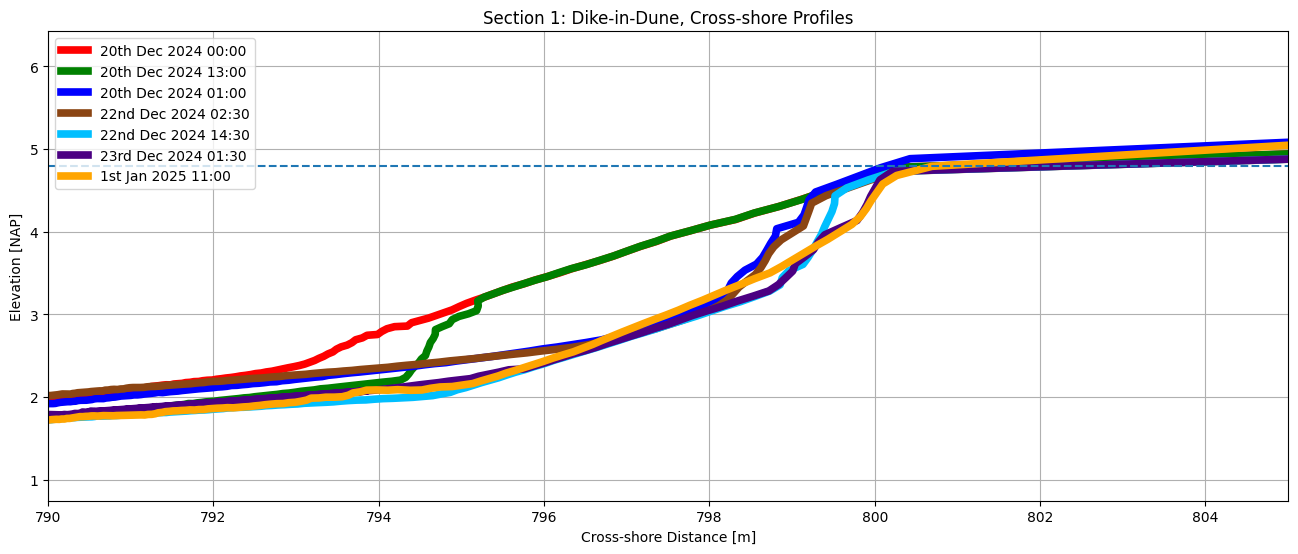

In [304]:
# Plot the transformed transects
plt.figure(figsize=(16, 8))

# Plot each dataframe with chosen colorpack
colors = ['red', 'green', 'blue', 'saddlebrown', 'deepskyblue', 'indigo', 'orange', 'purple', 'brown']

LW = 5.5

plt.plot(df1_1['x'], df1_1['z'], color=colors[0], linewidth=LW, label='20th Dec 2024 00:00')
plt.plot(df1_2['x'], df1_2['z'], color=colors[1], linewidth=LW, label='20th Dec 2024 13:00')
plt.plot(df1_3['x'], df1_3['z'], color=colors[2], linewidth=LW, label='20th Dec 2024 01:00')

plt.plot(df2_1['x'], df2_1['z'], color=colors[3], linewidth=LW, label='22nd Dec 2024 02:30')
plt.plot(df2_2['x'], df2_2['z'], color=colors[4], linewidth=LW, label='22nd Dec 2024 14:30')
plt.plot(df2_3['x'], df2_3['z'], color=colors[5], linewidth=LW, label='23rd Dec 2024 01:30')

plt.plot(df3_1['x'], df3_1['z'], color=colors[6], linewidth=LW, label='1st Jan 2025 11:00')
# plt.plot(df3_2['x'], df3_2['z'], color=colors[7], linewidth=LW, label='1st Jan 2025 23:00')
# plt.plot(df3_3['x'], df3_3['z'], color=colors[8], linewidth=LW, label='2nd Jan 2025 11:00')



# Plot line through teen_ns and kruin_ns
x = [teen_ns[0], kruin_ns[0]]
y = [teen_ns[2], kruin_ns[2]]
# plt.plot(x, y, color='grey', linewidth=4.5, label='Concrete Dike')

plt.xlabel('Cross-shore Distance [m]')
plt.ylabel('Elevation [NAP]')
plt.title('Section 1: Dike-in-Dune, Cross-shore Profiles')
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(loc='upper left')

plt.axhline(y=4.8, linestyle='--')

plt.xlim(790, 805)

plt.show()

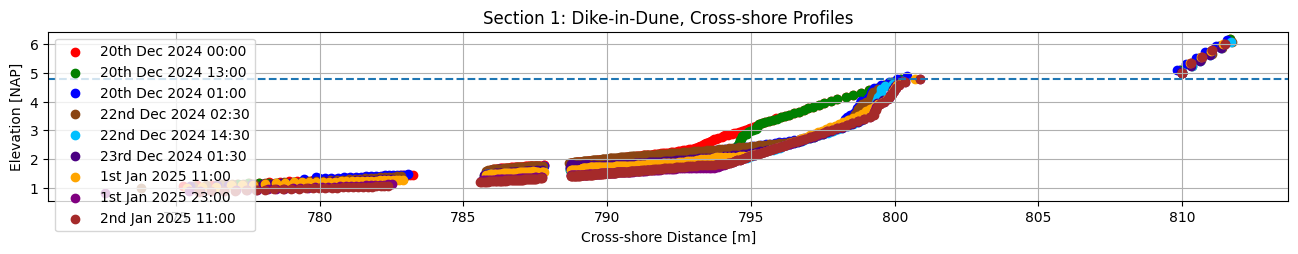

In [305]:
# Plot the transformed transects
plt.figure(figsize=(16, 8))

# Plot each dataframe with chosen colorpack
colors = ['red', 'green', 'blue', 'saddlebrown', 'deepskyblue', 'indigo', 'orange', 'purple', 'brown']

plt.scatter(df1_1['x'], df1_1['z'], color=colors[0], label='20th Dec 2024 00:00')
plt.scatter(df1_2['x'], df1_2['z'], color=colors[1], label='20th Dec 2024 13:00')
plt.scatter(df1_3['x'], df1_3['z'], color=colors[2], label='20th Dec 2024 01:00')

plt.scatter(df2_1['x'], df2_1['z'], color=colors[3], label='22nd Dec 2024 02:30')
plt.scatter(df2_2['x'], df2_2['z'], color=colors[4], label='22nd Dec 2024 14:30')
plt.scatter(df2_3['x'], df2_3['z'], color=colors[5], label='23rd Dec 2024 01:30')

plt.scatter(df3_1['x'], df3_1['z'], color=colors[6], label='1st Jan 2025 11:00')
plt.scatter(df3_2['x'], df3_2['z'], color=colors[7], label='1st Jan 2025 23:00')
plt.scatter(df3_3['x'], df3_3['z'], color=colors[8], label='2nd Jan 2025 11:00')



# Plot line through teen_ns and kruin_ns
x = [teen_ns[0], kruin_ns[0]]
y = [teen_ns[2], kruin_ns[2]]
# plt.plot(x, y, color='grey', linewidth=4.5, label='Concrete Dike')

plt.xlabel('Cross-shore Distance [m]')
plt.ylabel('Elevation [NAP]')
plt.title('Section 1: Dike-in-Dune, Cross-shore Profiles')
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(loc='upper left')

plt.axhline(y=4.8, linestyle='--')

# plt.xlim(790, 805)

plt.show()

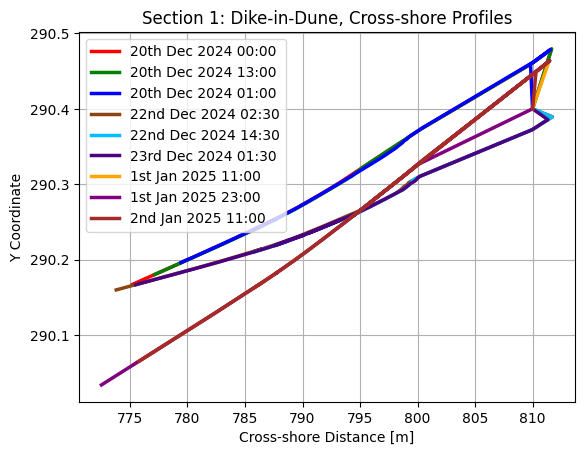

In [306]:
plt.plot(df1_1['x'], df1_1['y'], color=colors[0], linewidth=2.5, label='20th Dec 2024 00:00')
plt.plot(df1_2['x'], df1_2['y'], color=colors[1], linewidth=2.5, label='20th Dec 2024 13:00')
plt.plot(df1_3['x'], df1_3['y'], color=colors[2], linewidth=2.5, label='20th Dec 2024 01:00')

plt.plot(df2_1['x'], df2_1['y'], color=colors[3], linewidth=2.5, label='22nd Dec 2024 02:30')
plt.plot(df2_2['x'], df2_2['y'], color=colors[4], linewidth=2.5, label='22nd Dec 2024 14:30')
plt.plot(df2_3['x'], df2_3['y'], color=colors[5], linewidth=2.5, label='23rd Dec 2024 01:30')

plt.plot(df3_1['x'], df3_1['y'], color=colors[6], linewidth=2.5, label='1st Jan 2025 11:00')
plt.plot(df3_2['x'], df3_2['y'], color=colors[7], linewidth=2.5, label='1st Jan 2025 23:00')
plt.plot(df3_3['x'], df3_3['y'], color=colors[8], linewidth=2.5, label='2nd Jan 2025 11:00')

plt.xlabel('Cross-shore Distance [m]')
plt.ylabel('Y Coordinate')
plt.title('Section 1: Dike-in-Dune, Cross-shore Profiles')
plt.grid(True)
plt.legend(loc='upper left')

plt.show()

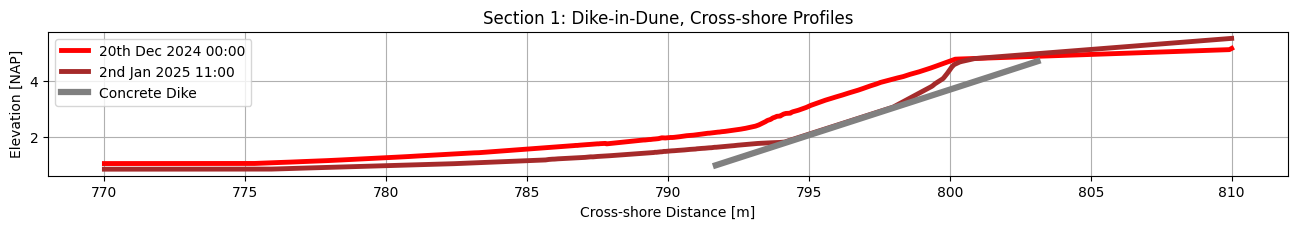

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the interpolation step
x_interp = np.linspace(770, 810, num=1000) # 4cm grid

# Function to interpolate the data
def interpolate_data(df, x_interp):
    z_interp = np.interp(x_interp, df['x'], df['z'])
    return z_interp

# Perform interpolation for each dataframe
z_interp_df1_1 = interpolate_data(df1_1, x_interp)
z_interp_df1_2 = interpolate_data(df1_2, x_interp)
z_interp_df1_3 = interpolate_data(df1_3, x_interp)

z_interp_df2_1 = interpolate_data(df2_1, x_interp)
z_interp_df2_2 = interpolate_data(df2_2, x_interp)
z_interp_df2_3 = interpolate_data(df2_3, x_interp)

z_interp_df3_1 = interpolate_data(df3_1, x_interp)
z_interp_df3_2 = interpolate_data(df3_2, x_interp)
z_interp_df3_3 = interpolate_data(df3_3, x_interp)

# Plot the original and interpolated data
plt.figure(figsize=(16, 8))

# Plot original data
# plt.scatter(df1_1['x'], df1_1['z'], color=colors[0], label='20th Dec 2024 00:00')
# plt.scatter(df1_2['x'], df1_2['z'], color=colors[1], label='20th Dec 2024 13:00')
# plt.scatter(df1_3['x'], df1_3['z'], color=colors[2], label='20th Dec 2024 01:00')

# plt.scatter(df2_1['x'], df2_1['z'], color=colors[3], label='22nd Dec 2024 02:30')
# plt.scatter(df2_2['x'], df2_2['z'], color=colors[4], label='22nd Dec 2024 14:30')
# plt.scatter(df2_3['x'], df2_3['z'], color=colors[5], label='23rd Dec 2024 01:30')

# plt.scatter(df3_1['x'], df3_1['z'], color=colors[6], label='1st Jan 2025 11:00')
# plt.scatter(df3_2['x'], df3_2['z'], color=colors[7], label='1st Jan 2025 23:00')
# plt.scatter(df3_3['x'], df3_3['z'], color=colors[8], label='2nd Jan 2025 11:00')

# Plot interpolated data
LW = 3.5

plt.plot(x_interp, z_interp_df1_1, color=colors[0], linestyle='-', linewidth=LW, label='20th Dec 2024 00:00')
# plt.plot(x_interp, z_interp_df1_2, color=colors[1], linestyle='-', linewidth=LW, label='20th Dec 2024 13:00')
# plt.plot(x_interp, z_interp_df1_3, color=colors[2], linestyle='-', linewidth=LW, label='20th Dec 2024 01:00')

# plt.plot(x_interp, z_interp_df2_1, color=colors[3], linestyle='-', linewidth=LW, label='22nd Dec 2024 02:30')
# plt.plot(x_interp, z_interp_df2_2, color=colors[4], linestyle='-', linewidth=LW, label='22nd Dec 2024 14:30')
# plt.plot(x_interp, z_interp_df2_3, color=colors[5], linestyle='-', linewidth=LW, label='23rd Dec 2024 01:30')

# # plt.plot(x_interp, z_interp_df3_1, color=colors[6], linestyle='-', linewidth=LW, label='1st Jan 2025 11:00')
# plt.plot(x_interp, z_interp_df3_2, color=colors[7], linestyle='-', linewidth=LW, label='1st Jan 2025 23:00')
plt.plot(x_interp, z_interp_df3_3, color=colors[8], linestyle='-', linewidth=LW, label='2nd Jan 2025 11:00')

# Plot line through teen_ns and kruin_ns
x = [teen_ns[0], kruin_ns[0]]
y = [teen_ns[2], kruin_ns[2]]
plt.plot(x, y, color='grey', linewidth=4.5, label='Concrete Dike')

plt.xlabel('Cross-shore Distance [m]')
plt.ylabel('Elevation [NAP]')
plt.title('Section 1: Dike-in-Dune, Cross-shore Profiles')
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(loc='upper left')

# plt.axhline(y=4.8, linestyle='--')

# plt.xlim(785, 805)

plt.show()
